# Import Packages

In [626]:

import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import*
import math
import csv
from IPython.display import display

from pyproj import Transformer 
from itertools import combinations

# Access Files

Creating Dataframe of particular country and particular links

In [627]:
filename = 'filtered_links.csv'
file_path = filename

df = pd.read_csv(file_path)
ireland_df = df[
    ((df['src_country'] == 'IE') | (df['dst_country'] == 'IE'))].copy()
ireland_df.sort_values(by = 'voltage' , ascending = True, inplace = True)




# Create Smaller dataframe but more meshed

Testing for nodes with more than 4 edge connections to test edges at 45 degree angles

In [628]:
""" link_id_list = [9503, 9513, 9502, 9495, 9493, 9496, 9494, 9508, 9499, 9519]

#link_id_list = [9499, 9519, 9496, 9494, 9508]     #, 9508

filtered_df = ireland_df[ireland_df['link_id'].isin(link_id_list)]

# Then, update the src_bus_id for the link_id 9520 in the filtered dataframe
#filtered_df.loc[filtered_df['link_id'] == 9520, 'src_bus_id'] = 6195
filtered_df.loc[filtered_df['link_id'] == 9493, 'dst_bus_id'] = 6187
filtered_df.loc[filtered_df['link_id'] == 9495, 'dst_bus_id'] = 6187
filtered_df.loc[filtered_df['link_id'] == 9496, 'src_bus_id'] = 6187 

display(filtered_df) """

" link_id_list = [9503, 9513, 9502, 9495, 9493, 9496, 9494, 9508, 9499, 9519]\n\n#link_id_list = [9499, 9519, 9496, 9494, 9508]     #, 9508\n\nfiltered_df = ireland_df[ireland_df['link_id'].isin(link_id_list)]\n\n# Then, update the src_bus_id for the link_id 9520 in the filtered dataframe\n#filtered_df.loc[filtered_df['link_id'] == 9520, 'src_bus_id'] = 6195\nfiltered_df.loc[filtered_df['link_id'] == 9493, 'dst_bus_id'] = 6187\nfiltered_df.loc[filtered_df['link_id'] == 9495, 'dst_bus_id'] = 6187\nfiltered_df.loc[filtered_df['link_id'] == 9496, 'src_bus_id'] = 6187 \n\ndisplay(filtered_df) "


## Create Medium 15 node dataframe


In [629]:
"""  #link_id_list = [9513, 9514, 9520, 9501, 9655, 9521, 9502, 9503, 9510, 9500, 9519, 9496, 9507, 9494, 9495]
## NOTE: src_bus id for two different links between red and green line have different number nodes
link_id_list = [9502, 9513, 9503, 9514, 9501, 9521, 9500, 9520, 9655, 9510, 9493, 9494, 9495, 9519, 9508, 9499, 9496]

filtered_df = ireland_df[ireland_df['link_id'].isin(link_id_list)]

# Then, update the src_bus_id for the link_id 9520 in the filtered dataframe
filtered_df.loc[filtered_df['link_id'] == 9520, 'src_bus_id'] = 6195
filtered_df.loc[filtered_df['link_id'] == 9493, 'dst_bus_id'] = 6187
filtered_df.loc[filtered_df['link_id'] == 9495, 'dst_bus_id'] = 6187

filtered_df.loc[filtered_df['link_id'] == 9496, 'src_bus_id'] = 6187




# To check the change, display the row with link_id 9520 from the filtered dataframe
display(filtered_df[filtered_df['link_id'] == 9520])
print(f"Shape of df is: {filtered_df.shape}")

display(filtered_df)  """

'  #link_id_list = [9513, 9514, 9520, 9501, 9655, 9521, 9502, 9503, 9510, 9500, 9519, 9496, 9507, 9494, 9495]\n## NOTE: src_bus id for two different links between red and green line have different number nodes\nlink_id_list = [9502, 9513, 9503, 9514, 9501, 9521, 9500, 9520, 9655, 9510, 9493, 9494, 9495, 9519, 9508, 9499, 9496]\n\nfiltered_df = ireland_df[ireland_df[\'link_id\'].isin(link_id_list)]\n\n# Then, update the src_bus_id for the link_id 9520 in the filtered dataframe\nfiltered_df.loc[filtered_df[\'link_id\'] == 9520, \'src_bus_id\'] = 6195\nfiltered_df.loc[filtered_df[\'link_id\'] == 9493, \'dst_bus_id\'] = 6187\nfiltered_df.loc[filtered_df[\'link_id\'] == 9495, \'dst_bus_id\'] = 6187\n\nfiltered_df.loc[filtered_df[\'link_id\'] == 9496, \'src_bus_id\'] = 6187\n\n\n\n\n# To check the change, display the row with link_id 9520 from the filtered dataframe\ndisplay(filtered_df[filtered_df[\'link_id\'] == 9520])\nprint(f"Shape of df is: {filtered_df.shape}")\n\ndisplay(filtered_df) 

# Create Large 220  kV DataFrame
Need to update the nodes that connect the 220 and 380 kV, some are labelled differently

In [630]:
#filtered_df = ireland_df[ireland_df['voltage'].isin([220])].copy()


filtered_df = ireland_df[ireland_df['voltage'].isin([220, 380])].copy()

# For the node 6178
filtered_df.loc[filtered_df['link_id'] == 9489, 'src_bus_id'] = 6179

# For the node 6195 
filtered_df.loc[filtered_df['link_id'] == 9520, 'src_bus_id'] = 6195

# Node 6187
filtered_df.loc[filtered_df['link_id'] == 9493, 'dst_bus_id'] = 6187
filtered_df.loc[filtered_df['link_id'] == 9495, 'dst_bus_id'] = 6187
filtered_df.loc[filtered_df['link_id'] == 9507, 'src_bus_id'] = 6187
filtered_df.loc[filtered_df['link_id'] == 9496, 'src_bus_id'] = 6187

print(f"Shape of df is: {filtered_df.shape}")
display(filtered_df)  




Shape of df is: (48, 14)


,link_id,src_bus_id,dst_bus_id,voltage,circuits,dc,underground,under_construction,length_m,tags,src_coord,dst_coord,src_country,dst_country
5611,9520,6195,6199,220.0,1,f,f,f,17218.410675,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.38256799999999, 53.120405)","(-8.59130900000001, 53.206033)",IE,IE
5612,9514,6174,6199,220.0,1,f,f,f,23300.746912,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.931885, 53.271783)","(-8.59130900000001, 53.206033)",IE,IE
5613,9505,6191,6200,220.0,2,f,t,f,11169.770576,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.43798799999999, 53.389881)","(-6.26220699999999, 53.396432)",IE,IE
5614,9511,6170,6200,220.0,1,f,t,f,9549.114280,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.11938500000001, 53.389881)","(-6.26220699999999, 53.396432)",IE,IE
5615,9523,6172,6201,220.0,1,f,f,f,8723.093809,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.17382799999999, 51.842566)","(-8.085938, 51.903613)",IE,IE
5616,9726,6171,6201,220.0,2,f,f,f,24540.982607,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.38256799999999, 52.038977)","(-8.085938, 51.903613)",IE,IE
5617,9748,6170,6202,220.0,1,f,t,f,10695.041304,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.11938500000001, 53.389881)","(-6.196289, 53.298056)",IE,IE
5618,9751,6190,6202,220.0,1,f,t,f,16539.224353,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.21826199999999, 53.14677)","(-6.196289, 53.298056)",IE,IE
5619,9749,6200,6202,220.0,1,f,t,f,11288.163928,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.26220699999999, 53.396432)","(-6.196289, 53.298056)",IE,IE
5583,9727,6172,6173,220.0,1,f,t,f,18598.289361,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.17382799999999, 51.842566)","(-8.4375, 51.808615)",IE,NaN


## Modify dataframe from the csv file
Coordinates are in longitude and latitude, so equivalent cartesian xy coordinates need to be found and added to dataframe

In [631]:
# Create Transformer object to convert geographic (WGS84) (EPSG:4326) coordinates to Web Mercator (EPSG: 3857)
# Converts to cartesian xy coordinates
 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# Function to transform a single coordinate tuple
def transform_coord(coord):
    # Check if coord is a string (e.g., "(lon, lat)") and convert it to a tuple
    if isinstance(coord, str):
        # Remove parentheses and split by comma
        coord = coord.strip("()").split(",")
        # Convert the split strings to floats and create a tuple
        coord = tuple(map(float, coord))
    
    # At this point, coord should be a tuple of floats (lon, lat)
    # Apply the transformation using the unpacked tuple
    return transformer.transform(*coord)


scaling_factor = 0.1

filtered_df[['src_x', 'src_y']] = filtered_df['src_coord'].apply(transform_coord).apply(pd.Series) * scaling_factor
filtered_df[['dst_x', 'dst_y']] = filtered_df['dst_coord'].apply(transform_coord).apply(pd.Series) * scaling_factor

display(filtered_df)
print(filtered_df)

,link_id,src_bus_id,dst_bus_id,voltage,circuits,dc,underground,under_construction,length_m,tags,src_coord,dst_coord,src_country,dst_country,src_x,src_y,dst_x,dst_y
5611,9520,6195,6199,220.0,1,f,f,f,17218.410675,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.38256799999999, 53.120405)","(-8.59130900000001, 53.206033)",IE,IE,-93314.320130,700530.071577,-95638.014313,702119.975351
5612,9514,6174,6199,220.0,1,f,f,f,23300.746912,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.931885, 53.271783)","(-8.59130900000001, 53.206033)",IE,IE,-99429.289002,703342.950548,-95638.014313,702119.975351
5613,9505,6191,6200,220.0,2,f,t,f,11169.770576,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.43798799999999, 53.389881)","(-6.26220699999999, 53.396432)",IE,IE,-71667.354589,705544.350521,-69710.569448,705666.642756
5614,9511,6170,6200,220.0,1,f,t,f,9549.114280,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.11938500000001, 53.389881)","(-6.26220699999999, 53.396432)",IE,IE,-68120.682217,705544.350521,-69710.569448,705666.642756
5615,9523,6172,6201,220.0,1,f,f,f,8723.093809,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.17382799999999, 51.842566)","(-8.085938, 51.903613)",IE,IE,-90990.637079,677170.927222,-90012.250075,678271.617658
5616,9726,6171,6201,220.0,2,f,f,f,24540.982607,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.38256799999999, 52.038977)","(-8.085938, 51.903613)",IE,IE,-93314.320130,680717.606642,-90012.250075,678271.617658
5617,9748,6170,6202,220.0,1,f,t,f,10695.041304,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.11938500000001, 53.389881)","(-6.196289, 53.298056)",IE,IE,-68120.682217,705544.350521,-68976.773629,703832.164368
5618,9751,6190,6202,220.0,1,f,t,f,16539.224353,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.21826199999999, 53.14677)","(-6.196289, 53.298056)",IE,IE,-69221.375946,701019.267668,-68976.773629,703832.164368
5619,9749,6200,6202,220.0,1,f,t,f,11288.163928,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-6.26220699999999, 53.396432)","(-6.196289, 53.298056)",IE,IE,-69710.569448,705666.642756,-68976.773629,703832.164368
5583,9727,6172,6173,220.0,1,f,t,f,18598.289361,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(-8.17382799999999, 51.842566)","(-8.4375, 51.808615)",IE,NaN,-90990.637079,677170.927222,-93925.820357,676559.429223


      link_id  src_bus_id  dst_bus_id  voltage  circuits dc underground  \
5611     9520        6195        6199    220.0         1  f           f   
5612     9514        6174        6199    220.0         1  f           f   
5613     9505        6191        6200    220.0         2  f           t   
5614     9511        6170        6200    220.0         1  f           t   
5615     9523        6172        6201    220.0         1  f           f   
5616     9726        6171        6201    220.0         2  f           f   
5617     9748        6170        6202    220.0         1  f           t   
5618     9751        6190        6202    220.0         1  f           t   
5619     9749        6200        6202    220.0         1  f           t   
5583     9727        6172        6173    220.0         1  f           t   
5610     9500        6193        6198    220.0         1  f           f   
5885     9639        6184        6549    220.0         1  f           f   
5886     9640        6183

## Functions
Calculate Forward Sector : Calculates the sector of an edge starting at the positive x axis going in counterclockwise direction. Sectors are split from 0 - 7.

![image.png](attachment:image.png)

In [632]:


def calculate_forward_sector(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    print("dx dy :")
    
    
    # Angle in radians
    angle_rad = math.atan2(dy, dx)
    
    # Convert to degreees
    angle_deg = math.degrees(angle_rad)
    
    # Angle is rounded to nearest multiple of 45
    # Sector value calculated, modulo 8 used 
    sector = round(angle_deg / 45) % 8
    
    return sector

def euclidean_distance(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    return math.sqrt((dx)**2 + (dy)**2)


def get_non_incident_edge_pairs(G):
    non_incident_edge_pairs = []
    
    # combinations - generates all possible pairs of edges from graph G without repeating the same pair
    # '2' indicates we're looking for combinationes of 2 edges
    for edge1, edge2 in combinations(G.edges(), 2):
        
        # edges are sets and the '&' checks that they have no common elements (ie nodes)
        if not set(edge1) & set(edge2):
            non_incident_edge_pairs.append((edge1, edge2))
    return non_incident_edge_pairs       













def midpoint(pos1, pos2):
    """Calculate the midpoint between two positions."""
    return ((pos1[0] + pos2[0]) / 2, (pos1[1] + pos2[1]) / 2)



def calculate_distance(midpoint1, midpoint2):
    return math.sqrt((midpoint2[0] - midpoint1[0]) ** 2 + (midpoint2[1] - midpoint1[1]) ** 2)

# Then use the renamed function in your code



def get_non_incident_edge_distance(G):
    non_incident_edge_distances = {}
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Calculate the midpoints for each edge
        midpoint1 = midpoint(src_pos1, tgt_pos1)
        midpoint2 = midpoint(src_pos2, tgt_pos2)

        # Calculate the distance between the midpoints of the two edges
        dist = calculate_distance(midpoint1, midpoint2)

        # Store the distance with the edge pair as the key
        non_incident_edge_distances[(edge1, edge2)] = dist

    return non_incident_edge_distances















def calculate_angle(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)  # Convert the angle to degrees
    
    # Normalize the angle to be within 0 to 360 degrees
    angle_degrees = (angle_degrees + 360) % 360

    return angle_degrees


 
def get_filtered_neighbour_order(G):
    
    # Convert the directed graph to an undirected graph to consider all adjacent nodes as neighbours
    G_undirected = G.to_undirected()
    
    # Create Dictionary to story nodes neighbour orders
    neighbour_order = {}
    for node in G_undirected.nodes():
        
        # Check if the node has 2 or more neighbours
        if G_undirected.degree(node) >= 2:
        
            # Access the position of the current node
            src_pos = G_undirected.nodes[node]['pos']
            src_x, src_y = src_pos
            
            # Create list to store angle size of neighbours with src node
            angles_neighbours = []
            
            
            
            for neighbour in G_undirected.neighbors(node):
                # Access the position tuple of the neighbour node using the 'pos' attribute
                dst_pos = G_undirected.nodes[neighbour]['pos']
                dst_x, dst_y = dst_pos
                
                # Calculate the angle from the source node to the neighbour node
                angle = calculate_angle(src_x, src_y, dst_x, dst_y)
                
                # Append the angle and neighbour to the list
                angles_neighbours.append((angle, neighbour)) 
                
                
            
            # Sort the list of (angle, neighbour) pairs by angle in ascending order
            angles_neighbours.sort()
            
            # Extract the sorted neighbours from the sorted list of pairs
            sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]
            
            # Check conditions to move the last neighbour to the first position
            if angles_neighbours[-1][0] > 315 and ((360 - angles_neighbours[-1][0]) < angles_neighbours[0][0]):
                # Move the last neighbour to the first position
                sorted_neighbours.insert(0, sorted_neighbours.pop())
            
            
            # Store the sorted list of neighbours in the dictionary with the src_node as the key
            neighbour_order[node] = sorted_neighbours
    
    return neighbour_order
   
     


# NetworkX Implementation
Dataframe is accessed where nodes and edges are added to graph. 
Forward and backward sector of a particular edge are found and stored as attributes along with the voltage information.

In [633]:

# Initialize a directed graph since we have source and destination
G = nx.DiGraph()

# Loop through the DataFrame rows to add edges and nodes to the graph
for index, row in filtered_df.iterrows():
    src_node = row['src_bus_id']
    dst_node = row['dst_bus_id']
    voltage = row['voltage']
    
    # Add the source and destination nodes if they don't already exist
    if src_node not in G:
        G.add_node(src_node, pos=(row['src_x'], row['src_y']))
    if dst_node not in G:
        G.add_node(dst_node, pos=(row['dst_x'], row['dst_y']))
        
        
        
    # Calculate the forward sector for edges
    forward_sector = calculate_forward_sector(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])

    # Backward sector
    backward_sector = (forward_sector + 4) % 8
    
    distance = euclidean_distance(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])
    
    # Add an edge between the source and destination nodes, voltage is attribute
    G.add_edge(src_node, dst_node, 
               voltage = voltage, 
               forward_sector = forward_sector, 
               backward_sector = backward_sector,
               distance = distance
               )


# Create list of non-incident edge pairs
non_incident_edge_pairs = get_non_incident_edge_pairs(G)

print(non_incident_edge_pairs)

# Find non-incident edges
#non_incident_edge_pairs = get_non_incident_edge_pairs(G)

# Print non-incident edge pairs
print("Non-incident edge pairs:")
for edge_pair in non_incident_edge_pairs:
    print(edge_pair)
    
ordered_neighbours_dict = get_filtered_neighbour_order(G)
print("\nNodes with more than 2 neighbours ordered:")
print(ordered_neighbours_dict)
for node, neighbours in ordered_neighbours_dict.items():
    print(len(neighbours))
    
    
 # dictionary
non_incident_edge_distances = get_non_incident_edge_distance(G)

# Find the non-incident edge pair with the maximum distance
max_distance_pair = max(non_incident_edge_distances, key=non_incident_edge_distances.get)

# Print the non-incident edge pair with the maximum distance and its value
max_distance_value = non_incident_edge_distances[max_distance_pair]
print(f"Non-incident edge pair with maximum distance: {max_distance_pair} with distance {max_distance_value}")
 

dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
dx dy :
[((6195, 6199), (6174, 6180)), ((6195, 6199), (6174, 6192)), ((6195, 6199), (6191, 6200)), ((6195, 6199), (6191, 6193)), ((6195, 6199), (6200, 6202)), ((6195, 6199), (6170, 6200)), ((6195, 6199), (6170, 6202)), ((6195, 6199), (6172, 6201)), ((6195, 6199), (6172, 6173)), ((6195, 6199), (6201, 7705)), ((6195, 6199), (6171, 6201)), ((6195, 6199), (6171, 6197)), ((6195, 6199), (6171, 6177)), ((6195, 6199), (6171, 6196)), ((6195, 6199), (6171, 7705)), ((6195, 6199), (6202, 6585)), ((6195, 6199), (6190, 6202)), ((6195, 6199), (6190, 6585)), ((6195, 6199), (6173, 7705)), ((6195, 6199), (6193, 6198)), ((6195, 6199), 

## Drawing NetworkX Graph

C:\Users\katec\AppData\Local\Temp\ipykernel_10704\2423779982.py:18: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width = 3, arrows = False)


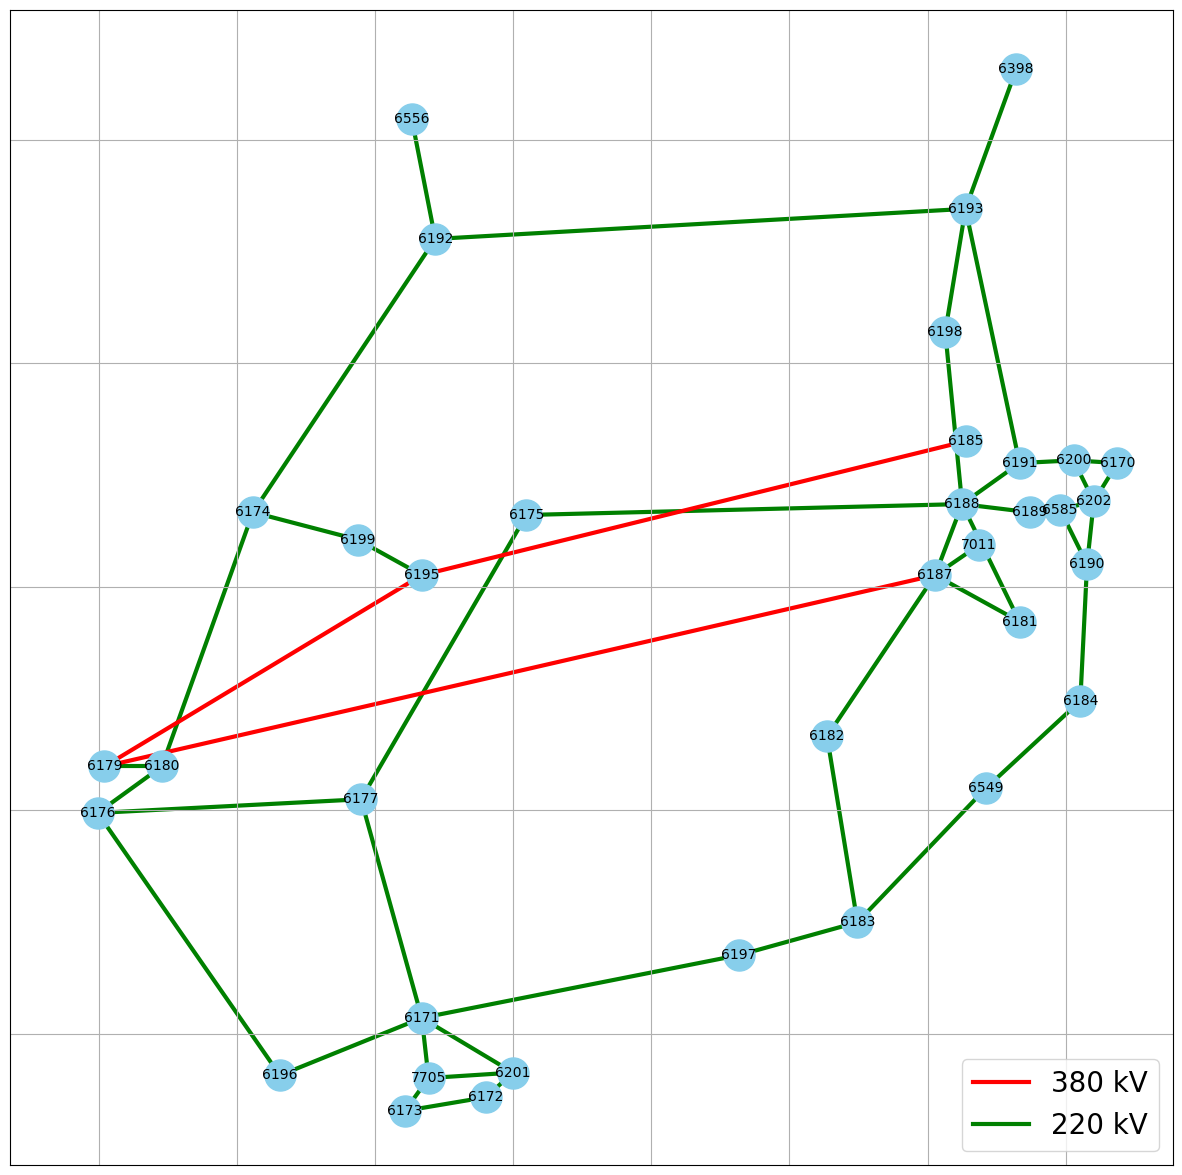

In [634]:
import matplotlib.lines as mlines

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize = (15, 15))
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)

# Create custom lines for the legend
red_line = mlines.Line2D([], [], color='red', markersize=30, label='380 kV', linewidth = 3)
green_line = mlines.Line2D([], [], color='green', markersize=30, label='220 kV', linewidth = 3)



# Draw the graph edges with different colors based on the voltage
for (u, v, d) in G.edges(data=True):
    edge_color = 'r' if d['voltage'] == 380.0 else 'g' if d['voltage'] == 220.0 else 'k' 
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width = 3, arrows = False)

# Draw the node labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Create edge labels for voltages
edge_labels = nx.get_edge_attributes(G, 'link_id')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=7)
#nx.draw_networkx_edge_labels(G, pos, label_pos=0.5, font_size=7)


# Add the legend to the plot
plt.legend(handles=[red_line, green_line], loc='lower right', fontsize = 20)

plt.grid(True)
# Show the plot
plt.show()

## Create Dictionary to access edge information

In [635]:
def get_edge_info(G, edge):
    node1, node2 = edge
    
    # edge attributes eg voltage forward/backward sector are stored in edge data
    edge_data = G.get_edge_data(node1, node2)
    
    # Additional edge information
    edge_information = {
        'edge': edge,
        'source': node1,
        'destination': node2,
        'source_position': G.nodes[node1].get('pos'),
        'destination_position': G.nodes[node2].get('pos'),
        'source_neighbors': list(G.successors(node1)),  # or list(G.successors(u)) for DiGraph
        'destination_neighbors': list(G.predecessors(node2)),  # or list(G.predecessors(v)) for DiGraph
        'source_degree': G.degree(node1),
        'destination_degree': G.degree(node2)
    }
    
    # Merge edge_data into edge_info
    edge_information.update(edge_data)
    return edge_information

    
    
# Usage example
edge_details = {}
for edge in G.edges():
    edge_details[edge] = get_edge_info(G, edge)
    print(edge_details[edge])
    
    forward = edge_details[edge].get('forward_sector')
    backward = edge_details[edge].get('backward_sector')
    print(f"Forward sector for edge {edge}: {forward}")
    print(f"Backward sector for edge {edge}: {backward}\n") 

{'edge': (6195, 6199), 'source': 6195, 'destination': 6199, 'source_position': (-93314.32012999886, 700530.0715766218), 'destination_position': (-95638.01431276694, 702119.9753507258), 'source_neighbors': [6199], 'destination_neighbors': [6195, 6174], 'source_degree': 3, 'destination_degree': 2, 'voltage': 220.0, 'forward_sector': 3, 'backward_sector': 7, 'distance': 2815.554770545278}
Forward sector for edge (6195, 6199): 3
Backward sector for edge (6195, 6199): 7

{'edge': (6174, 6199), 'source': 6174, 'destination': 6199, 'source_position': (-99429.28900240782, 703342.9505480125), 'destination_position': (-95638.01431276694, 702119.9753507258), 'source_neighbors': [6199, 6180, 6192], 'destination_neighbors': [6195, 6174], 'source_degree': 3, 'destination_degree': 2, 'voltage': 220.0, 'forward_sector': 0, 'backward_sector': 4, 'distance': 3983.645579803752}
Forward sector for edge (6174, 6199): 0
Backward sector for edge (6174, 6199): 4

{'edge': (6174, 6180), 'source': 6174, 'destin

In [636]:
# Debugging to check the sectors around the node 6188

# Usage example
edge_details = {}
for edge in G.edges():
    # Check if the node 6188 is part of the edge
    if 6188 in edge:
        edge_details[edge] = get_edge_info(G, edge)
        print(edge_details[edge])
        
        forward = edge_details[edge].get('forward_sector')
        backward = edge_details[edge].get('backward_sector')
        print(f"Forward sector for edge {edge}: {forward}")
        print(f"Backward sector for edge {edge}: {backward}\n") 


{'edge': (6187, 6188), 'source': 6187, 'destination': 6188, 'source_position': (-74724.83345955035, 700530.0715766218), 'destination_position': (-73746.44645496838, 703709.8559885431), 'source_neighbors': [7011, 6188], 'destination_neighbors': [6175, 6181, 6187], 'source_degree': 5, 'destination_degree': 6, 'voltage': 220.0, 'forward_sector': 2, 'backward_sector': 6, 'distance': 3326.9009659189546}
Forward sector for edge (6187, 6188): 2
Backward sector for edge (6187, 6188): 6

{'edge': (6188, 6198), 'source': 6188, 'destination': 6198, 'source_position': (-73746.44645496838, 703709.8559885431), 'destination_position': (-74357.946681794, 711414.718442685), 'source_neighbors': [6198, 6189, 6191], 'destination_neighbors': [6193, 6188], 'source_degree': 6, 'destination_degree': 2, 'voltage': 220.0, 'forward_sector': 2, 'backward_sector': 6, 'distance': 7729.090371101402}
Forward sector for edge (6188, 6198): 2
Backward sector for edge (6188, 6198): 6

{'edge': (6188, 6189), 'source': 618

In [637]:
## Function to get index of nodes in the ordered neighbours list.

# This function initializes the set of (node, index) pairs, where 'node' is a node with 2 or more neighbors,
# and 'index' is a unique integer (starting from 1) representing the position of a neighbor in the
# counterclockwise ordering of neighbors around 'node'.

def node_neighbour_index_pairs_init(model):
    node_index_pairs = []
    for node, neighbors in ordered_neighbours_dict.items():
        # Start index from 0 for each node's neighbors
        for idx in range(0, len(neighbors)):
            node_index_pairs.append((node, idx))
    return node_index_pairs

## Function to get dynamic min length for edges

In [638]:
# to get dynamic min length 
# Minimum length percentage
min_length_percentage = 0.1  # Adjust as needed

# Dictionary to store dynamic minimum lengths for each edge
dynamic_min_lengths = {}

for edge in G.edges():
    edge_info = get_edge_info(G, edge)
    
    forward = edge_info.get('forward_sector')
    backward = edge_info.get('backward_sector')
    
    if forward in (1, 3, 5, 7) or backward in (1, 3, 5, 7):
        dynamic_min_length = edge_info['distance'] *0.11
    else:
        # Assuming 'distance' is an attribute in edge_info; if not, calculate it from positions
        dynamic_min_length = edge_info['distance'] * min_length_percentage
    
    # Store the calculated dynamic minimum length in the dictionary
    dynamic_min_lengths[edge] = dynamic_min_length
    
"""


for edge in G.edges():
    edge_info = get_edge_info(G, edge)
    
    forward = edge_info.get('forward_sector')
    backward = edge_info.get('backward_sector')
    
    if forward in (1, 3, 5, 7) or backward in (1, 3, 5, 7):
        dynamic_min_length = edge_info['distance'] * 0.07
    else:
        dynamic_min_length = edge_info['distance'] * min_length_percentage
    
    # Round to nearest multiple of 100 and ensure it's at least 100
    dynamic_min_length = max(200, round(dynamic_min_length / 100) * 100)
    
    
    # Store the calculated dynamic minimum length in the dictionary
    dynamic_min_lengths[edge] = dynamic_min_length
""" 

print(dynamic_min_lengths) 


{(6195, 6199): 309.7110247599806, (6174, 6199): 398.3645579803752, (6174, 6180): 1184.34588504396, (6174, 6192): 1528.9060620678829, (6191, 6200): 196.06028356685601, (6191, 6193): 1154.0925677336052, (6200, 6202): 197.5795349187747, (6170, 6200): 159.45835817988893, (6170, 6202): 210.57097270057005, (6172, 6201): 161.99383580518574, (6172, 6173): 299.82045754602996, (6201, 7705): 306.72473958788413, (6171, 6201): 452.02543955094865, (6171, 6197): 1183.524651098953, (6171, 6177): 1002.8532096015939, (6171, 6196): 631.7148809706171, (6171, 7705): 270.1684320994538, (6202, 6585): 127.68409764265766, (6190, 6202): 282.3511667203163, (6190, 6585): 263.44091805277554, (6173, 7705): 186.89339918924256, (6193, 6198): 555.2162206518608, (6193, 6398): 650.1441439608288, (6184, 6549): 572.025531929084, (6184, 6190): 611.9849374902356, (6183, 6549): 834.1899346545546, (6183, 6197): 452.50752111231054, (6192, 6556): 544.8835837519899, (6192, 6193): 1924.8046104575515, (6189, 6585): 110.74682356503

## Check for Intersecting Edges

In [639]:
from shapely.geometry import LineString

def list_edge_intersections(G):
    intersecting_edge_pairs = []
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect
        if line1.intersects(line2):
            # If they intersect, add the edge pair to the list
            intersecting_edge_pairs.append((edge1, edge2))

    return intersecting_edge_pairs

# Call the function to get intersecting edge pairs
intersecting_edges = list_edge_intersections(G)

# Print the intersecting edge pairs
for edge_pair in intersecting_edges:
    print(f"Intersecting Edge Pair: {edge_pair}")

Intersecting Edge Pair: ((6174, 6180), (6179, 6187))
Intersecting Edge Pair: ((6174, 6180), (6179, 6195))
Intersecting Edge Pair: ((6188, 6198), (6185, 6195))
Intersecting Edge Pair: ((6175, 6177), (6179, 6187))
Intersecting Edge Pair: ((6175, 6177), (6185, 6195))
Intersecting Edge Pair: ((6175, 6188), (6185, 6195))


## Create new list of non intersecting non incident edges

In [640]:
# Create a new list excluding intersecting edge pairs
non_intersecting_non_incident_edges = [edge_pair for edge_pair in non_incident_edge_pairs if edge_pair not in intersecting_edges]

# Print the new list of non-intersecting, non-incident edge pairs
for edge_pair in non_intersecting_non_incident_edges:
    print(f"Non-Intersecting Non-Incident Edge Pair: {edge_pair}")

Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6174, 6180))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6174, 6192))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6191, 6200))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6191, 6193))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6200, 6202))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6170, 6200))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6170, 6202))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6172, 6201))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6172, 6173))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6201, 7705))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6171, 6201))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6171, 6197))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6171, 6177))
Non-Intersecting Non-Incident Edge Pair: ((6195, 6199), (6171, 6196))
Non-Intersecting Non

# Optimisation

In [641]:
model = ConcreteModel()



print(list(G.nodes()))
print(list(G.edges()))
# Set used to index the other components eg Param and Var, and to define the scope
model.Nodes = Set(initialize = list(G.nodes()))
model.Edges = Set(initialize = list(G.edges()))

# Initialize set of non-incident edge pairs
# dimen = 4: creates a collection of edge pairs where each pair is treated as a single tuple, 2 integers per edge
model.NonIncidentEdges = Set(initialize = non_incident_edge_pairs, dimen=4)
model.NonIntersecting_NonIncidentEdges = Set(initialize = non_intersecting_non_incident_edges, dimen=4)


# Set with 2 or more neighbours
# Storing set nodes with 2 or more neighbours that were predetermined in the dictionary
model.NodesWith2Neighbours = Set(initialize = ordered_neighbours_dict.keys())


# Initialize the set with the function that provides the (node, index) pairs
model.NodeNeighbours2IndexPairs = Set(dimen=2, initialize=node_neighbour_index_pairs_init)





### PARAM ###
## Param - fixed value in model that doesn't change during optimisation process ##
# pos defined earlier as tuple (x, y) in graph G
model.x_init = Param(model.Nodes, initialize={node: pos[node][0] for node in G.nodes()})
model.y_init = Param(model.Nodes, initialize={node: pos[node][1] for node in G.nodes()})


# Access information from dictionary of the edge info
edge_info = {edge: get_edge_info(G, edge) for edge in G.edges()}

# Initialize Params for static attributes from the edges
model.voltage = Param(model.Edges, initialize={edge: edge_info[edge]['voltage'] for edge in model.Edges})
model.sect_forward = Param(model.Edges, initialize={edge: edge_info[edge]['forward_sector'] for edge in model.Edges})
model.sect_backward = Param(model.Edges, initialize={edge: edge_info[edge]['backward_sector'] for edge in model.Edges})
model.distance = Param(model.Edges, initialize={edge: edge_info[edge]['distance'] for edge in model.Edges} )
#model.non_incident_edges = Param(model.Edges, initialize = {edge: edge_info[edge]['non_incident_edges'] for edge in model.Edges} )


# Param to store the ordered neighbors for each node in the model
model.OrderedNeighbours = Param(
    model.NodesWith2Neighbours,  # Index set for the Param, representing nodes with 2 or more neighbors
    within=Any,  # Specifies that the Param can hold any type of data, in this case, tuples of nodes
    initialize=lambda model, node: tuple(ordered_neighbours_dict[node])  # Initialization function
    # lambda function takes 2 arguments model and node (element from set Nodewith2Neigbours)
    # for each node, it gets the list or ordered neighbours from the dictionary
    # list is converted to tuple so that for Param, the contents are unchangeable
)
   





### VARIABLES ###
## Define Variables ##
model.x_pos = Var(model.Nodes, within = Reals, initialize = model.x_init)
model.y_pos = Var(model.Nodes, within = Reals, initialize = model.y_init)

model.z1_pos = Expression(model.Nodes, rule = lambda model, node: model.x_pos[node] + model.y_pos[node])
model.z2_pos = Expression(model.Nodes, rule = lambda model, node: model.x_pos[node] - model.y_pos[node])


model.dir_forward = Var(model.Edges, within = Integers, bounds = (0, 7))
model.dir_backward = Var(model.Edges, within = Integers, bounds = (0, 7))


# Binary variable for octilinear constraint to determine where edge is drawn
model.alpha_pred = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_orig = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_succ = Var(model.Edges, within = Binary, bounds = (0, 1))


# Binary Variable for non-incident edge constraint
model.is_N = Var(model.NonIncidentEdges, within=Binary)
model.is_S = Var(model.NonIncidentEdges, within=Binary)
model.is_E = Var(model.NonIncidentEdges, within=Binary)
model.is_W = Var(model.NonIncidentEdges, within=Binary)
model.is_NE = Var(model.NonIncidentEdges, within=Binary)
model.is_NW = Var(model.NonIncidentEdges, within=Binary)
model.is_SE = Var(model.NonIncidentEdges, within=Binary)
model.is_SW = Var(model.NonIncidentEdges, within=Binary)

model.delta_pred = Var(model.Edges, within = Integers, bounds = (0, 7))
model.delta_orig = Var(model.Edges, within = Integers, bounds = (0, 7))
model.delta_succ = Var(model.Edges, within = Integers, bounds = (0, 7))


max_degree = max(len(neighbors) for neighbors in ordered_neighbours_dict.values())


# Define Beta as a binary variable indexed by the (node, index) pairs
# Beta[node, idx] will be used in the constraints to identify the "wrap-around" point
# in the counterclockwise ordering of neighbors around each node
model.Beta = Var(model.NodeNeighbours2IndexPairs, within=Binary)




# Redefine rpos as a continuous variable representing the deviation magnitude
model.rpos = Var(model.Edges, within=NonNegativeReals)





#model.rpos = Var(model.Edges, within=Binary)


[6195, 6199, 6174, 6191, 6200, 6170, 6172, 6201, 6171, 6202, 6190, 6173, 6193, 6198, 6184, 6549, 6183, 6192, 6556, 6585, 6189, 6187, 7011, 7705, 6398, 6188, 6197, 6175, 6177, 6176, 6179, 6180, 6182, 6181, 6196, 6185]
[(6195, 6199), (6174, 6199), (6174, 6180), (6174, 6192), (6191, 6200), (6191, 6193), (6200, 6202), (6170, 6200), (6170, 6202), (6172, 6201), (6172, 6173), (6201, 7705), (6171, 6201), (6171, 6197), (6171, 6177), (6171, 6196), (6171, 7705), (6202, 6585), (6190, 6202), (6190, 6585), (6173, 7705), (6193, 6198), (6193, 6398), (6184, 6549), (6184, 6190), (6183, 6549), (6183, 6197), (6192, 6556), (6192, 6193), (6189, 6585), (6187, 7011), (6187, 6188), (6188, 6198), (6188, 6189), (6188, 6191), (6175, 6177), (6175, 6188), (6176, 6177), (6176, 6180), (6176, 6196), (6179, 6180), (6179, 6187), (6179, 6195), (6182, 6183), (6182, 6187), (6181, 6187), (6181, 6188), (6185, 6195)]


### Debugging

In [642]:
""" ## DEBUGGING
for pair in model.NodeNeighbours2IndexPairs:
    print(pair)


for node in model.NodesWith2Neighbours:
    print(f"Node: {node}, Ordered Neighbours: {model.OrderedNeighbours[node]}")
    print(len(model.OrderedNeighbours[node]) - 1)

for node, index in model.NodeNeighbours2IndexPairs:
    print(f"Beta[{node}, {index}]: {model.Beta[node, index]}")
    
print(len(model.OrderedNeighbours[node]) - 1) """

' ## DEBUGGING\nfor pair in model.NodeNeighbours2IndexPairs:\n    print(pair)\n\n\nfor node in model.NodesWith2Neighbours:\n    print(f"Node: {node}, Ordered Neighbours: {model.OrderedNeighbours[node]}")\n    print(len(model.OrderedNeighbours[node]) - 1)\n\nfor node, index in model.NodeNeighbours2IndexPairs:\n    print(f"Beta[{node}, {index}]: {model.Beta[node, index]}")\n    \nprint(len(model.OrderedNeighbours[node]) - 1) '

# Octilinearity Constraint

In [643]:
#M= 10000

# Sum of Binary variables is equal to 1
# node1 and node2 are the src and dst nodes defined in model.Edges
def alpha_direction_constraint(model, node1, node2):
    return model.alpha_pred[node1, node2] + model.alpha_orig[node1, node2] + model.alpha_succ[node1, node2] == 1
model.alpha_direction_constraint = Constraint(model.Edges, rule = alpha_direction_constraint)


 
 # for each edge in tuple (node1, node2) in model.Edges, dir constraint is called and formed
def dir_forward_constraint(model, node1, node2):
    
    
    sect_forward_pred = (model.sect_forward[node1, node2] - 1) % 8
    sect_forward_orig = model.sect_forward[node1, node2]
    sect_forward_succ = (model.sect_forward[node1, node2] + 1) % 8
    
     # Debugging: Print the values of sectors and binary variables
    """ print(f"Edge: {(node1, node2)}")
    print(f"sect_forward_pred: {sect_forward_pred}, sect_forward_orig: {sect_forward_orig}, sect_forward_succ: {sect_forward_succ}")
    print(f"alpha_pred[{node1}, {node2}]: {model.alpha_pred[node1, node2].value}")
    print(f"alpha_orig[{node1}, {node2}]: {model.alpha_orig[node1, node2].value}")
    print(f"alpha_succ[{node1}, {node2}]: {model.alpha_succ[node1, node2].value}") """
    
    
    
    return model.dir_forward[node1, node2] == ((sect_forward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_forward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_forward_succ * model.alpha_succ[node1, node2])
                                        )

model.DirForwardConstraint = Constraint(model.Edges, rule=dir_forward_constraint)
 

def dir_backward_constraint(model, node1, node2):
    sect_backward_pred = (model.sect_backward[node1, node2] - 1) % 8
    sect_backward_orig = model.sect_backward[node1, node2]
    sect_backward_succ = (model.sect_backward[node1, node2] + 1) % 8
    
      # Debugging: Print the values of sectors and binary variables
    """ print(f"Edge: {(node1, node2)}")
    print(f"sect_backward_pred: {sect_backward_pred}, sect_backward_orig: {sect_backward_orig}, sect_backward_succ: {sect_backward_succ}")
    print(f"alpha_pred[{node1}, {node2}]: {model.alpha_pred[node1, node2].value}")
    print(f"alpha_orig[{node1}, {node2}]: {model.alpha_orig[node1, node2].value}")
    print(f"alpha_succ[{node1}, {node2}]: {model.alpha_succ[node1, node2].value}")  """
    
    return model.dir_backward[node1, node2] == ((sect_backward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_backward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_backward_succ * model.alpha_succ[node1, node2])
                                        )
    
model.DirBackwardConstraint = Constraint(model.Edges, rule = dir_backward_constraint) 




 
def sector_constraints_rule(model, node1, node2):

    # Retrieve original sector and minimum edge length
    sect_orig = model.sect_forward[node1, node2]
    min_length = dynamic_min_lengths[(node1, node2)] #(model.distance[node1, node2])*0.1  #1000
    #min_length = 1400
    
    
    # Define a large constant M for making constraints trivial when not active
    M = 30000  # Adjust as needed

    # Iterate over each alpha variable and its corresponding sector adjustment
    for alpha, adjustment in zip([model.alpha_pred, model.alpha_orig, model.alpha_succ], [-1, 0, 1]):
        # Adjusted sector based on alpha variable
        sect_adjusted = (sect_orig + adjustment) % 8

        # Conditions based on adjusted sector
        if sect_adjusted in [0, 4]:  # Horizontal
            model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.y_pos[node1] + model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            
            if sect_adjusted == 0:
                # For sector 0, node1 should be to the left of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node2] - model.x_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
            elif sect_adjusted == 4:
                # For sector 4, node1 should be to the right of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))
                
        
        elif sect_adjusted in [2, 6]:  # Vertical
            # Add corresponding constraints for this sector
            model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.x_pos[node1] + model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            if sect_adjusted == 2:  # Upwards
                # Node2's y_pos should be at least min_length above Node1's y_pos
                model.sector_constraints.add(model.y_pos[node2] - model.y_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
            elif sect_adjusted == 6:  # Downwards
                # Node2's y_pos should be at least min_length below Node1's y_pos
                model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))






        elif sect_adjusted == 1:         #upright diagonal /
            # dx = dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) - (model.x_pos[node2] - model.x_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # dx + dy >= min length of diagonal
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))
            
        elif sect_adjusted == 5:        # Diagonal downwards /
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # -dx - dy >= min length
            # negative diagonal
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))

            


            
        ## Diagonal \
            
        elif sect_adjusted == 3:    # Up left diagonal \
            # -dx = dy
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dx is negative
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) <= 0)
            
            # -dx + dy >= min length (dx is negative value)
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            
            
            
        elif sect_adjusted == 7:    # Down right Diagonal \
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dy is negative
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) <= 0)
        
            # dx - dy >= min length (since dy is negative, we use -dy)
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
   




       



       
            # Fill in your constraints similar to above
    return Constraint.Skip 

# Initialize the constraint list on your model if not already done
model.sector_constraints = ConstraintList()

# Apply the rule to each edge
model.SectorConstraint = Constraint(model.Edges, rule=sector_constraints_rule)

 
 

 

   


## Circular Vertex Order
The initial circular ordering of neighbour nodes (counterclockwise) should be the same after optimisation.

For each node in the map, the sequence in which the neighbouring nodes are arranged around a particular node should match the order in which the neighbouring nodes are arranged in the final layout.

In [644]:
## Helper Function for the circular vertex order
## Determines if node with more than 2 neighbours is the source or destination node
## So the correct direction can be assigned to it

def directional_sector(model, node, neighbor):
    if (node, neighbor) in model.Edges:
        return model.dir_forward[node, neighbor]
    elif (neighbor, node) in model.Edges:
        return model.dir_backward[neighbor, node]
    else:
        return None  # This case should ideally never happen if the graph is well-defined

In [645]:
# Beta Binary Sum Constraint


def beta_sum_constraint_rule(model, node):
    # Ensure we use 0-based indexing to match the updated indexing in Beta
    # Note that RangeSet in Pyomo starts from 1, so we adjust the range accordingly
    return sum(model.Beta[node, index] for index in range(0, len(model.OrderedNeighbours[node]) )) == 1

model.BetaSumConstraint = Constraint(model.NodesWith2Neighbours, rule=beta_sum_constraint_rule)




# Define the ConstraintList in your Pyomo model
model.OrderMaintenanceConstraints = ConstraintList()


def add_order_maintenance_constraints(model):
    for node, neighbours in ordered_neighbours_dict.items():
        num_neighbours = len(neighbours)
        
        
        for index in range(num_neighbours):
            print(index)
            # Handle all neighbor pairs except the last pair (which wraps around)
            if index < num_neighbours - 1:
                next_index = index + 1
            else:
                next_index = 0      # wrap around case
                
                
            # Use the helper function to dynamically select dir_forward or dir_backward
            dir_sect = directional_sector(model, node, neighbours[index])
            next_dir_sect = directional_sector(model, node, neighbours[next_index])
            
            # Debugging prints before adding the constraint
            print(f"Node: {node}, Neighbour: {neighbours[index]}, Directional Sector: {dir_sect}")
            print(f"Node: {node}, Next Neighbour: {neighbours[next_index]}, Next Directional Sector: {next_dir_sect}")
            if index == num_neighbours - 1:  # For wrap-around case
                print(f"\nNode: {node}, Index: {index}, Beta: {model.Beta[node, index].value if model.Beta[node, index].value is not None else 'Not solved yet'}")

            
            
            if dir_sect is not None and next_dir_sect is not None:
                    model.OrderMaintenanceConstraints.add(dir_sect <= next_dir_sect - 1 + 8*model.Beta[node, index])

                

            
           
# Call the function to add the constraints to the ConstraintList
add_order_maintenance_constraints(model) 

0
Node: 6195, Neighbour: 6185, Directional Sector: dir_backward[6185,6195]
Node: 6195, Next Neighbour: 6199, Next Directional Sector: dir_forward[6195,6199]
1
Node: 6195, Neighbour: 6199, Directional Sector: dir_forward[6195,6199]
Node: 6195, Next Neighbour: 6179, Next Directional Sector: dir_backward[6179,6195]
2
Node: 6195, Neighbour: 6179, Directional Sector: dir_backward[6179,6195]
Node: 6195, Next Neighbour: 6185, Next Directional Sector: dir_backward[6185,6195]

Node: 6195, Index: 2, Beta: Not solved yet
0
Node: 6199, Neighbour: 6195, Directional Sector: dir_backward[6195,6199]
Node: 6199, Next Neighbour: 6174, Next Directional Sector: dir_backward[6174,6199]
1
Node: 6199, Neighbour: 6174, Directional Sector: dir_backward[6174,6199]
Node: 6199, Next Neighbour: 6195, Next Directional Sector: dir_backward[6195,6199]

Node: 6199, Index: 1, Beta: Not solved yet
0
Node: 6174, Neighbour: 6199, Directional Sector: dir_forward[6174,6199]
Node: 6174, Next Neighbour: 6192, Next Directional

## Edge Spacing 
Each edge must have a distance of at least dmin > 0 from each non incident edge.

- Prevents edge crossings
- maintains planarity (edges have minimum separation in at least 1 octilinear direction)
- enhances visualisation
- preserves topology structure

In [646]:
def non_incident_edge_direction_constraint_rule(model, u1, v1, u2, v2):
    
    e1 = (u1, v1)
    e2 = (u2, v2)
        
    return (model.is_N[e1, e2] + model.is_S[e1, e2] + model.is_E[e1, e2] + model.is_W[e1, e2] +
            model.is_NE[e1, e2] + model.is_NW[e1, e2] + model.is_SE[e1, e2] + model.is_SW[e1, e2] >= 1)
    
#model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)
model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIntersecting_NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)

# Initialize ConstraintList outside of function
# Adds new constraints to list in model without reinitializing it
model.edgeSpacingConstraints = ConstraintList()

def edge_spacing_constraint(model, u1, v1, u2, v2):
    dmin = 900
    
    ## infeasibility coming from too small M value due to large distances between
    M = 30000
    
    
    e1 = (u1, v1)
    e2 = (u2, v2)
    
    # is_N[e1, e2] means that e1 is north of e1
    
    ## North Constraint
    c1 = model.y_pos[u2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c2 = model.y_pos[v2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c3 = model.y_pos[u2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c4 = model.y_pos[v2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin

    
    # South
    c5 = model.y_pos[u1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c6 = model.y_pos[v1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c7 = model.y_pos[u1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c8 = model.y_pos[v1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin

    
    # is_E[e1, e2] = 1 means that e1 is East of e2
    ## East
    c9 = model.x_pos[u2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c10 = model.x_pos[v2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c11 = model.x_pos[u2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c12 = model.x_pos[v2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin

    
    
    
    ## West
    c13 = model.x_pos[u1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c14 = model.x_pos[v1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c15 = model.x_pos[u1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c16 = model.x_pos[v1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin

    
    
    ## NE
    c17 = model.z1_pos[u2] - model.z1_pos[u1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c18 = model.z1_pos[v2] - model.z1_pos[u1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c19 = model.z1_pos[u2] - model.z1_pos[v1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c20 = model.z1_pos[v2] - model.z1_pos[v1] <= M * (1 - model.is_NE[e1, e2]) - dmin

    
    
    ## NW
    c21 = model.z2_pos[u1] - model.z2_pos[u2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c22 = model.z2_pos[u1] - model.z2_pos[v2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c23 = model.z2_pos[v1] - model.z2_pos[u2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c24 = model.z2_pos[v1] - model.z2_pos[v2] <= M * (1 - model.is_NW[e1, e2]) - dmin

    
    
    # SE
    c25 = model.z2_pos[u2] - model.z2_pos[u1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c26 = model.z2_pos[v2] - model.z2_pos[u1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c27 = model.z2_pos[u2] - model.z2_pos[v1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c28 = model.z2_pos[v2] - model.z2_pos[v1] <= M * (1 - model.is_SE[e1, e2]) - dmin

    
    
    
    
    ## SW
    c29 = model.z1_pos[u1] - model.z1_pos[u2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c30 = model.z1_pos[u1] - model.z1_pos[v2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c31 = model.z1_pos[v1] - model.z1_pos[u2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c32 = model.z1_pos[v1] - model.z1_pos[v2] <= M * (1 - model.is_SW[e1, e2]) - dmin

    
    constraint_list = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c30, c31, c32]

    # Add all constraints to the constraint list
    for constraint in constraint_list:
        model.edgeSpacingConstraints.add(constraint)
 
 
 
        
# Call edge_spacing_constraint for each non-incident edge pair
for u1, v1, u2, v2 in model.NonIncidentEdges:
    edge_spacing_constraint(model, u1, v1, u2, v2)
        
 


# Relative Position Constraint and Objective Function

In [647]:



# Updated constraint without Big M
def rpos_constraint_upper(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= model.dir_forward[u, v] - model.sect_forward[u, v]

model.RposConstraintUpper = Constraint(model.Edges, rule=rpos_constraint_upper)

# Updated constraint without Big M
def rpos_constraint_lower(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= -model.dir_forward[u, v] + model.sect_forward[u, v]

model.RposConstraintLower = Constraint(model.Edges, rule=rpos_constraint_lower)

# Objective function to minimize the sum of the deviations
def relative_position_cost(model):
    OF = sum(model.rpos[edge] for edge in model.Edges)
    print(f"cost is: {OF}")
    return OF

model.RelativePositionObjective = Objective(rule=relative_position_cost, sense=minimize)


cost is: rpos[6195,6199] + rpos[6174,6199] + rpos[6174,6180] + rpos[6174,6192] + rpos[6191,6200] + rpos[6191,6193] + rpos[6200,6202] + rpos[6170,6200] + rpos[6170,6202] + rpos[6172,6201] + rpos[6172,6173] + rpos[6201,7705] + rpos[6171,6201] + rpos[6171,6197] + rpos[6171,6177] + rpos[6171,6196] + rpos[6171,7705] + rpos[6202,6585] + rpos[6190,6202] + rpos[6190,6585] + rpos[6173,7705] + rpos[6193,6198] + rpos[6193,6398] + rpos[6184,6549] + rpos[6184,6190] + rpos[6183,6549] + rpos[6183,6197] + rpos[6192,6556] + rpos[6192,6193] + rpos[6189,6585] + rpos[6187,7011] + rpos[6187,6188] + rpos[6188,6198] + rpos[6188,6189] + rpos[6188,6191] + rpos[6175,6177] + rpos[6175,6188] + rpos[6176,6177] + rpos[6176,6180] + rpos[6176,6196] + rpos[6179,6180] + rpos[6179,6187] + rpos[6179,6195] + rpos[6182,6183] + rpos[6182,6187] + rpos[6181,6187] + rpos[6181,6188] + rpos[6185,6195]


# Solver

In [648]:

#solver.solve(model, tee=True)  # 'tee=True' enables solver output
#Solve the model
solver = SolverFactory('gurobi')
results = solver.solve(model, tee = True)

# Assuming 'results' contains the solver results
print(results.solver.status)
print(results.solver.termination_condition)


def extract_solver_stats(results):
    stats = {
        'Solver Status': str(results.solver.status),
        'Termination Condition': str(results.solver.termination_condition),
        'Solve Time (s)': results.solver.time,
        'Number of Constraints': results.problem.number_of_constraints,
        'Number of Variables': results.problem.number_of_variables,
        'Number of Nonzeros': results.problem.number_of_nonzeros
    }
    if results.solver.status == 'ok' and results.solver.termination_condition == 'optimal':
        stats['Objective Value'] = int(value(model.RelativePositionObjective.expr))
    else:
        stats['Objective Value'] = 'N/A'
    return stats



Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file C:\Users\katec\AppData\Local\Temp\tmpwj58po3e.pyomo.lp
Reading time = 0.12 seconds
x1: 34648 rows, 8660 columns, 142208 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 34648 rows, 8660 columns and 142208 nonzeros
Model fingerprint: 0x32f51728
Variable types: 120 continuous, 8540 integer (8444 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 3e+04]


Presolve removed 1749 rows and 628 columns
Presolve time: 0.98s
Presolved: 32899 rows, 8032 columns, 127347 nonzeros
Variable types: 68 continuous, 7964 integer (7935 binary)

Root relaxation: objective 7.000000e+00, 5466 iterations, 0.96 seconds (1.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.00000    0   18          -    7.00000      -     -    2s
     0     0   10.00000    0  605          -   10.00000      -     -    4s
     0     0   10.00000    0  773          -   10.00000      -     -    5s
     0     0   10.00000    0  889          -   10.00000      -     -    6s
     0     0   10.00000    0  888          -   10.00000      -     -    6s
     0     0   10.00000    0  573          -   10.00000      -     -    7s
     0     0   10.00000    0  488          -   10.00000      -     -    7s
H    0     0                      16.0000000   16.00000  0

# NetworkX Graph

C:\Users\katec\AppData\Local\Temp\ipykernel_10704\1609603594.py:30: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, updated_pos, edgelist=[(u, v)], edge_color=edge_color, width=3, arrows = False)


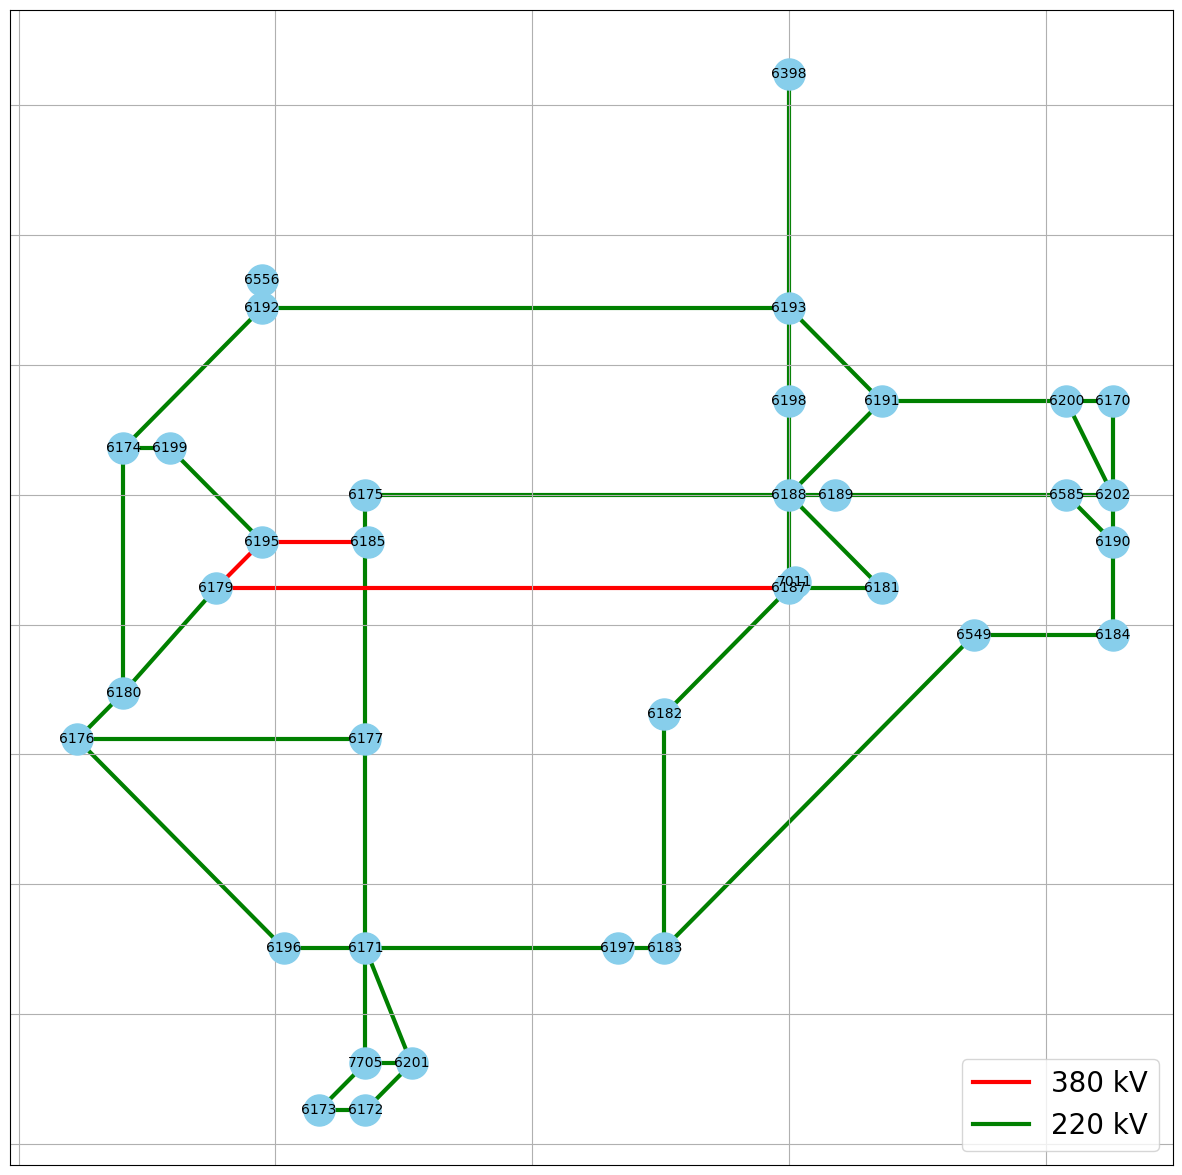

In [649]:


import matplotlib.pyplot as plt
import matplotlib.lines as mlines


# First, ensure that you have defined 'value' function to extract values from the model
# Assuming value function is like this:
# def value(model_attribute):
#     return model_attribute()  # Adjust depending on how your model returns values

# Update positions based on optimized x and y coordinates
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}

# Increase the figure size
plt.figure(figsize=(15, 15))

# Draw nodes with updated positions
nx.draw_networkx_nodes(G, updated_pos, node_color='skyblue', node_size=500)


# Create custom lines for the legend
red_line = mlines.Line2D([], [], color='red', markersize=20, label='380 kV', linewidth = 3)
green_line = mlines.Line2D([], [], color='green', markersize=20, label='220 kV', linewidth = 3)




# Draw the graph edges with different colors based on the voltage using updated positions
for (u, v, d) in G.edges(data=True):
    edge_color = 'r' if d['voltage'] == 380.0 else 'g' if d['voltage'] == 220.0 else 'k'
    nx.draw_networkx_edges(G, updated_pos, edgelist=[(u, v)], edge_color=edge_color, width=3, arrows = False)

# Draw the node labels with updated positions
nx.draw_networkx_labels(G, updated_pos, font_size=10)

# Get the edge labels for the link_ids
edge_labels = nx.get_edge_attributes(G, 'link_id')

# Draw the edge labels with updated positions
nx.draw_networkx_edge_labels(G, updated_pos, edge_labels=edge_labels, label_pos=0.5, font_size=7)

# Optionally, if you want to make the plot title and axes invisible
#plt.title("Optimized Graph")
plt.axis('on')  # Turn off the axis

# Add the legend to the plot
plt.legend(handles=[red_line, green_line], loc='lower right', fontsize = 20)
plt.grid(True)

# Show the plot with the optimized graph
plt.show()




In [650]:
# Assuming 'G' is your graph and 'model' is your Pyomo model
# Updated positions based on optimized x and y coordinates
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}

# Initialize a list to store edge information along with the calculated angles
opt_edges_info = []

# Iterate through each edge in your graph
for edge in G.edges():
    node1, node2 = edge

    # Retrieve the updated positions for source and destination nodes
    src_x, src_y = updated_pos[node1]
    dst_x, dst_y = updated_pos[node2]

    # Calculate the angle using the updated positions
    angle = calculate_angle(src_x, src_y, dst_x, dst_y)

    formatted_angle = round(angle, 2)

    # Append the edge information and formatted angle to the list
    opt_edges_info.append({
        'Edge': edge,
        'Source': node1,
        'Destination': node2,
        'Angle (degrees)': formatted_angle  # Use the formatted angle
    })

# Convert the list of dictionaries to a pandas DataFrame for easy tabular display
opt_edges_info_df = pd.DataFrame(opt_edges_info)

# Print the DataFrame
#print(edges_info_df)
display(opt_edges_info_df)

,Edge,Source,Destination,Angle (degrees)
0,"(6195, 6199)",6195,6199,135.00
1,"(6174, 6199)",6174,6199,0.00
2,"(6174, 6180)",6174,6180,270.00
3,"(6174, 6192)",6174,6192,45.00
4,"(6191, 6200)",6191,6200,0.00
5,"(6191, 6193)",6191,6193,135.00
6,"(6200, 6202)",6200,6202,296.57
7,"(6170, 6200)",6170,6200,180.00
8,"(6170, 6202)",6170,6202,270.00
9,"(6172, 6201)",6172,6201,45.00


In [651]:
def count_octilinearity_violations(opt_edges_info):
    violations = 0
    for edge_info in opt_edges_info:
        angle = edge_info['Angle (degrees)']
        # Check if the angle is not an exact multiple of 45 (including 0)
        if angle % 45 != 0:
            violations += 1
    return violations

# Count the number of octilinearity violations using the updated edge information
octilinearity_violations = count_octilinearity_violations(opt_edges_info)

# Print the number of octilinearity violations
print(f"Number of Octilinearity Violations: {octilinearity_violations}")


def lines_intersect(line1, line2):
    """Check if two lines (each defined by two points) intersect."""
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    A, B = line1
    C, D = line2

    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

def count_edge_crossings(G, pos):
    crossings = 0
    edges = list(G.edges())
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            edge1, edge2 = edges[i], edges[j]
            if not set(edge1) & set(edge2):  # Ensure edges are not incident
                line1 = (pos[edge1[0]], pos[edge1[1]])
                line2 = (pos[edge2[0]], pos[edge2[1]])
                if lines_intersect(line1, line2):
                    crossings += 1
    return crossings



def count_edge_crossings(G, pos):
    crossings = 0
    edges = list(G.edges())
    for i in range(len(edges)):
        for j in range(i + 1, len(edges)):
            edge1, edge2 = edges[i], edges[j]
            if not set(edge1) & set(edge2):  # Ensure edges are not incident
                line1 = (pos[edge1[0]], pos[edge1[1]])
                line2 = (pos[edge2[0]], pos[edge2[1]])
                if lines_intersect(line1, line2):
                    crossings += 1
    return crossings

def calculate_edge_statistics(G, pos):
    # Use your custom euclidean_distance function to calculate lengths
    lengths = [euclidean_distance(pos[u][0], pos[u][1], pos[v][0], pos[v][1]) for u, v in G.edges()]
    avg_length = sum(lengths) / len(lengths) if lengths else 0
    std_dev_length = pd.Series(lengths).std() if lengths else 0
    min_length = min(lengths) if lengths else 0
    max_length = max(lengths) if lengths else 0
    return avg_length, std_dev_length, (min_length, max_length)


def calculate_node_displacement(initial_pos, updated_pos):
    displacements = [euclidean_distance(initial_pos[node][0], initial_pos[node][1], updated_pos[node][0], updated_pos[node][1]) for node in initial_pos]
    total_displacement = sum(displacements)
    return total_displacement

Number of Octilinearity Violations: 3


In [652]:


def display_results(stats, num_crossings, avg_length, std_dev_length, length_range, displacement, octilinearity_violations):
    
    

    # Round the other values to 2 decimal places
    avg_length = round(avg_length, 2)
    std_dev_length = round(std_dev_length, 2)
    length_range = (round(length_range[0], 2), round(length_range[1], 2))
    displacement = round(displacement, 2)
    
    results_df = pd.DataFrame([
        ['Solver Status', stats['Solver Status']],
        ['Objective Function Value', stats.get('Objective Value', 'N/A')],
        ['Computation Time (s)', stats['Solve Time (s)']],
        ['Number of Iterations', stats.get('Iterations', 'N/A')],
        
        ['Number of Constraints', stats['Number of Constraints']],
        ['Number of Variables', stats['Number of Variables']],
        
        ['Number of Edge Crossings', num_crossings],
        ['Octilinearity Violations', octilinearity_violations],  

        ['Edge Length Average', avg_length],
        ['Edge Length Standard Deviation', std_dev_length],
        ['Edge Length Range', f"{length_range[0]} to {length_range[1]}"],
        ['Total Node Displacement', displacement]
    ], columns=['Metric', 'Value'])
    
    display(results_df)
    #print(results_df.to_string(index=False))
    
stats = extract_solver_stats(results)

# Check for the number of iterations and add it to stats
if hasattr(results.solver, 'iterations'):
    stats['Number of Iterations'] = results.solver.iterations
else:
    stats['Number of Iterations'] = 'Not provided by solver'

initial_pos = nx.get_node_attributes(G, 'pos')  # Assuming initial positions are stored as node attributes
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}
num_crossings = count_edge_crossings(G, updated_pos)
avg_length, std_dev_length, length_range = calculate_edge_statistics(G, updated_pos)
displacement = calculate_node_displacement(initial_pos, updated_pos)
# Example usage
display_results(stats, num_crossings, avg_length, std_dev_length, length_range, displacement, octilinearity_violations)


,Metric,Value
0,Solver Status,ok
1,Objective Function Value,16
2,Computation Time (s),15.964496
3,Number of Iterations,N/A
4,Number of Constraints,34648
5,Number of Variables,8660
6,Number of Edge Crossings,2
7,Octilinearity Violations,3
8,Edge Length Average,2981.72
9,Edge Length Standard Deviation,2478.1
